# 다양한 OCR 모델 비교하기
앞서 Google OCR API, keras-ocr, Tesseract 3가지 OCR 기능을 활용해 보았다.  
OCR 기술이 많이 발전은 했지만 완전한 수준은 아니기에 용도에 맞게 적절한 것을 선택하는게 중요하다.  
위 3가지 기능에 대한 검증을 진행하는게 이번 프로젝트이다.  

In [1]:
import keras_ocr
import pytesseract
import matplotlib.pyplot as plt


print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


In [2]:
# pip install --upgrade google-api-python-client

In [3]:
# pip install google-cloud-vision

## 검증용 데이터셋 준비
검증용 데이터는 직접 만든 손글씨....  
추가로 Google OCR API로 잘 불러와졌는지 테스트

In [4]:
import os
import numpy as np
img_path = os.getenv('HOME')+'/aiffel/ocr_python/words/'
img_list = []
for i in range(1,21):
    image = img_path + str(i) + '.PNG'
    img_list.append(image)
    
img_list

['/aiffel/aiffel/ocr_python/words/1.PNG',
 '/aiffel/aiffel/ocr_python/words/2.PNG',
 '/aiffel/aiffel/ocr_python/words/3.PNG',
 '/aiffel/aiffel/ocr_python/words/4.PNG',
 '/aiffel/aiffel/ocr_python/words/5.PNG',
 '/aiffel/aiffel/ocr_python/words/6.PNG',
 '/aiffel/aiffel/ocr_python/words/7.PNG',
 '/aiffel/aiffel/ocr_python/words/8.PNG',
 '/aiffel/aiffel/ocr_python/words/9.PNG',
 '/aiffel/aiffel/ocr_python/words/10.PNG',
 '/aiffel/aiffel/ocr_python/words/11.PNG',
 '/aiffel/aiffel/ocr_python/words/12.PNG',
 '/aiffel/aiffel/ocr_python/words/13.PNG',
 '/aiffel/aiffel/ocr_python/words/14.PNG',
 '/aiffel/aiffel/ocr_python/words/15.PNG',
 '/aiffel/aiffel/ocr_python/words/16.PNG',
 '/aiffel/aiffel/ocr_python/words/17.PNG',
 '/aiffel/aiffel/ocr_python/words/18.PNG',
 '/aiffel/aiffel/ocr_python/words/19.PNG',
 '/aiffel/aiffel/ocr_python/words/20.PNG']

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

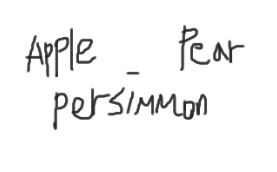

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'
detect_text(img_list[0])

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


Texts:

"Pear
Apple
Persimmon"

"Pear"

"Apple"

"Persimmon"
bounds: (48,88),(206,85),(207,121),(49,124)


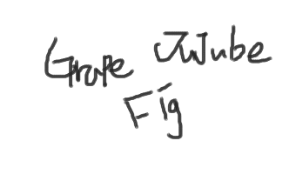

In [7]:
detect_text(img_list[1])

Texts:

"Grape Jujube
Fig"

"Grape"

"Jujube"

"Fig"
bounds: (117,85),(166,76),(178,140),(128,149)


### keras-ocr 써보기 
텐서플로우 기반 OCR 모델 구현  
검출 모델로는 CRAFT(Character Region Awareness for Text Detection)을 사용,  
인식 모델은 CRNN 사용

In [8]:
import matplotlib.pyplot as plt

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [9]:
images = [keras_ocr.tools.read(img) for img in img_list]
prediction_groups = [pipeline.recognize([img]) for img in img_list]

pipelin.recognize()에 이미지를 넣어주고 pyplot으로 시각화  
내부에 recognize()는 검출기와 인식기를 두고  
검출기로 바운딩 박스(Bounding Box, 문자 영역 정보)를 검출하고  
인식기로 각 바운딩 박스로부터 문자를 인식하는 과정을 거친다.  

주의사항) keras-ocr은 한글 훈련이 되어있지 않은 모델  
detection은 정상진행되어도 recognition은 결과가 정확하지 않을 수 있다.

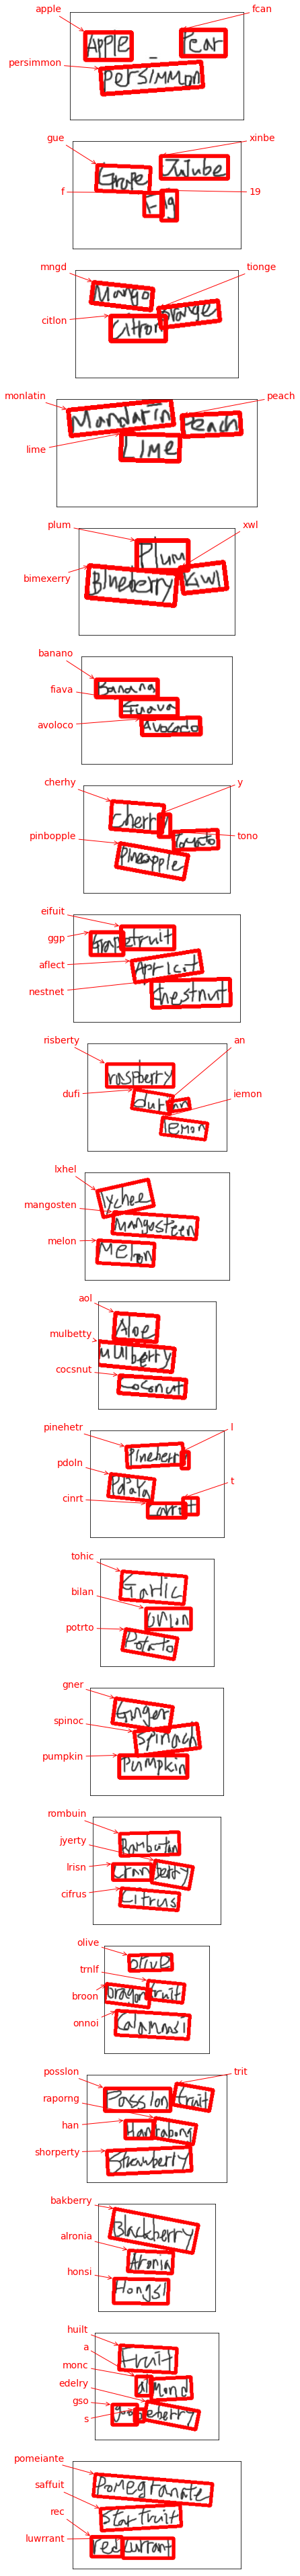

In [14]:
fig, axs = plt.subplots(nrows=len(images), figsize=(100,70))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

keras-ocr은 내 글씨체를 완벽하게 분석하지 못하였다. 악필인 듯 하다

### Tesseract 사용해보기
설치  

In [11]:
# sudo apt install tesseract-ocr
# sudo apt install libtesseract-dev

문자 검출하고 이미지 자르기(Detection)

In [12]:
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]

        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]

            output_img_path = os.path.join(output_path, f"{str(index).zfill(3)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/words'
for i in range(1,21):
    img_file_path = work_dir + '/' + str(i) + '.PNG'   
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir + '/words/word0' + str(i))

/aiffel/aiffel/ocr_python/words/words/word01/000.png
/aiffel/aiffel/ocr_python/words/words/word01/001.png
/aiffel/aiffel/ocr_python/words/words/word01/002.png
/aiffel/aiffel/ocr_python/words/words/word01/003.png
/aiffel/aiffel/ocr_python/words/words/word02/000.png
/aiffel/aiffel/ocr_python/words/words/word02/001.png
/aiffel/aiffel/ocr_python/words/words/word02/002.png
/aiffel/aiffel/ocr_python/words/words/word02/003.png
/aiffel/aiffel/ocr_python/words/words/word03/000.png
/aiffel/aiffel/ocr_python/words/words/word03/001.png
/aiffel/aiffel/ocr_python/words/words/word03/002.png
/aiffel/aiffel/ocr_python/words/words/word04/000.png
/aiffel/aiffel/ocr_python/words/words/word04/001.png
/aiffel/aiffel/ocr_python/words/words/word04/002.png
/aiffel/aiffel/ocr_python/words/words/word05/000.png
/aiffel/aiffel/ocr_python/words/words/word05/001.png
/aiffel/aiffel/ocr_python/words/words/word06/000.png
/aiffel/aiffel/ocr_python/words/words/word06/001.png
/aiffel/aiffel/ocr_python/words/words/word06/0

위의 crop_word_regions() 함수는 선택한 이미지를 받아 문자를 검출한 후  
검출 문자 영역을 crop한 이미지로 만들어 파일 list를 리턴하는 함수  
기본적으로 pytesseract.image_to_data()를 사용함  
파이썬에서 편하게 쓰기 위해 pytesseract의 Output을 딕셔너리 형식으로 설정해준다.  
이 딕셔너리는 바운딩 박스의 left, top, width, height의 정보를 가진다.  
바운딩 박스를 사용해 이미지 문자 영역들을 PIL 또는 OpenCV 라이브러리를 사용해 잘라내어 cropped_image_path_list에 담아 리턴

In [13]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(crop_word_regions(img_file_path, work_dir + '/words/word020'))

/aiffel/aiffel/ocr_python/words/words/word020/000.png
/aiffel/aiffel/ocr_python/words/words/word020/001.png
/aiffel/aiffel/ocr_python/words/words/word020/002.png
/aiffel/aiffel/ocr_python/words/words/word020/003.png
/aiffel/aiffel/ocr_python/words/words/word020/004.png
/aiffel/aiffel/ocr_python/words/words/word020/005.png
Poreg

On gety.

Stat

truit

(ed

Luton}

Done


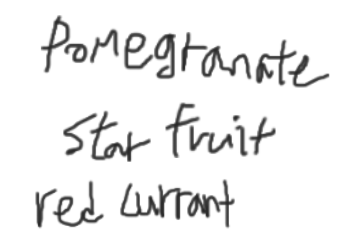

테서렉트 또한 내 글씨를 잘 인식하지 못한다. 악필임이 확실하다.  
내 손글씨에 한해서는 구글 OCR API가 제일 정확하다